<center>
<div style="max-width:400px;">

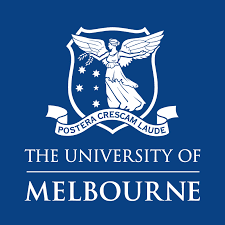

</div>
</center>

# Catapult Design of Experiments

**Prof. Kevin Otto and Nikolas Crossan**  
The University of Melbourne  
Department of Mechanical Engineering

----------------------------------------------------------------------------

This notebook demonstrates a capstone problem on creating and analyzing factorial designs.  It starts with a fractional factorial design and finishes with a central composite design expansion.

This notebook relies on the `mqr-quality` code library, found at https://pypi.org/project/mqr-quality/



In [ ]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack, grab_figure
from mqr.doe import Design

from importlib.metadata import version
print('MQR version', version('mqr-quality'))
print('Numpy version ', version('numpy'))
print('Scipy version ', version('scipy'))
print('Pandas version ', version('pandas'))
print('Seaborn version ', version('seaborn'))
print('StatsModels version ', version('statsmodels'))

# 1. Create Fractional Factorial Design with Center Points


## 1.1 Fractional Factorial Design

Next is code to create a fractional factorial matrix as a Pandas Dataframe.  Here a $2^{4-1}$ fractional factorial design.  

Each column's formula is given as a standard letter format such as $\{a \  b \ c \  abc\}$ for the four columns. There will be $\{ a \  b \  c\} = 3$ independent factors and so $2^3=8$ experimental configurations.  


In [ ]:
var_list = ["Ht", "Theta0", "Ra", "Rc"]
var = 'a b c abc'
frd = Design.from_fracfact(var_list, var)
frd

## 1.3 Center Points

Augmenting any factorial design is easy enough by adding rows of zero values to a factorial DataFrame. 

Now create a Pandas DataFrame which includes a column indicating whether a factorial point or a center point.

In [ ]:
nc = 3    # number of centerpoints
cfd = Design.from_fracfact(var_list, var) + Design.from_centrepoints(var_list, nc)
cfd

## 1.3 Catapult Runs

Now go and run the catapult at these conditions, tossing several times, such as 4-6, and report back the pull back angle error ($s$) and average toss distance ($d_{bar}$). 

Enter these into the Pandas dataframe.  

In [ ]:
df_cfd = cfd.to_df()
df_cfd['s'] = [0.03933, 0.00775, 0.08559, 0.02442, 0.04389, 0.01330, 0.70346, 0.13574, 0.07319, 0.04056, 0.05514]
df_cfd['dbar'] = [0.1303, 0.5980, 0.9433, 0.9585, 0.5633, 0.7920, 1.4740, 1.8148, 1.0333, 1.0275, 1.0115]
df_cfd

## 1.4 Curvature Analysis

Check if there is curvature or not by fitting the model and including a categorical term PtType to test for curvature.

The base fractional factorial design is a $2^{4-1}$ design, and so several 2-way interactions are confounded.  It is left to the student to show that 
$$
\begin{aligned}
     ab = cd \\
     ac = bd \\
     ad = bc
\end{aligned}
$$
Therefore, only one of each of these can be fit.  

In [ ]:
f = '''
    s ~
    Ht + Theta0 + Ra + Rc +
    I(Ht*Theta0) + I(Ht*Ra) + I(Ht*Rc) +
    + C(PtType)
'''
model_s = smf.ols(formula=f, data=df_cfd)
res_s = model_s.fit()

sanova = mqr.anova.coeffs(res_s)

effect = 's'
cornerdata = df_cfd.query('PtType == 1')
centerdata = df_cfd.query('PtType == 0')

with Figure(8, 2, 1, len(var_list)) as (fig, axs):
    for name, ax in zip(var_list, axs):
        ax.plot(cornerdata.groupby(name).mean()[effect], color='C0')
        ax.plot(centerdata.groupby(name).mean()[effect], color='C1', marker='o')
        ax.set_xlabel(name)
        plot = grab_figure(fig)

vstack(
    plot,
    sanova)

Here we found curvature in $s$ since the p-value for PtType was 0.021 and was significant, and so a regression analysis is pointless.  Now repeat and check $d_{bar}$ for curvature.  

In [ ]:
f = '''
    dbar ~
    Ht + Theta0 + Ra + Rc +
    I(Ht*Theta0) + I(Ht*Ra) + I(Ht*Rc) +
    + C(PtType)
'''
model_s = smf.ols(formula=f, data=df_cfd)
res_s = model_s.fit()

danova = mqr.anova.coeffs(res_s)

effect = 'dbar'

with Figure(8, 2, 1, len(var_list)) as (fig, axs):
    for name, ax in zip(var_list, axs):
        ax.plot(cornerdata.groupby(name).mean()[effect], color='C0')
        ax.plot(centerdata.groupby(name).mean()[effect], color='C1', marker='o')
        ax.set_xlabel(name)
        ax.set_ylabel('dbar')
        plot = grab_figure(fig)

vstack(
    plot,
    danova
)

Again $d_{bar}$ has curvature. From this analysis, both $s$ and $d_{bar}$ have curvature.  A fractional factorial design is inadequate and an expansion to a CCD design is needed.

----------------------------------------------------------------------------------

# 2. Central Composite Design

## 2.1 Central Composite Design Creation

We will construct a fractional factorial CCD array with 4 variables.  First we re-create the fractional factorialwith add center points as one block. Then we create an axial point DOE and also add center points, as a second block.  

In [ ]:
ccfrd = (
    Design.from_fracfact(var_list, 'a b c abc').as_block(1) +
    Design.from_centrepoints(var_list, nc).as_block(1) +
    Design.from_axial(var_list, magnitude=np.sqrt(2)).as_block(2) +
    Design.from_centrepoints(var_list, nc).as_block(2)
)

## 2.2 Augmented Experimental Runs

Now suppose the experiments were executed at each run. Add the toss results of each run to the dataframe.  

In [ ]:
df_ccfrd = ccfrd.to_df()
df_ccfrd['s'] = [
    0.03933, 0.00775, 0.08559, 0.02442, 0.04389, 0.01330, 0.70346, 0.13574, 0.07319, 0.04056, 0.05514,
    0.07549, 0.07769, 0.01251, 0.08805, 0.03704, 0.08831, 0.04899, 0.05811, 0.07359, 0.06219, 0.02240]
df_ccfrd['dbar'] = [
    0.1303, 0.5980, 0.9433, 0.9585, 0.5633, 0.7920, 1.4740, 1.8148, 1.0333, 1.0275, 1.0115,
    0.8068, 1.2543, -0.0750, 0.9763, 0.7950, 1.2235, 0.8045, 1.1753, 0.9930, 1.0070, 1.0413]
df_ccfrd

## 2.3 Test for Block Differences

First test if the two blocks are the same by comparing the means of the center points.

In [ ]:
block1 = df_ccfrd.query('Block == 1')
block2 = df_ccfrd.query('Block == 2')
centers1 = block1.query('PtType == 0')['s']
centers2 = block2.query('PtType == 0')['s']

ev = False           # 'PtType == 1'True for equal variances
alt = 'two-sided'    # 'less', 'two-sided', 'greater'
mqr.inference.mean.test_2sample(
    centers1,
    centers2,
    pooled=ev,
    alternative=alt
)

So there is no significant difference, the blocks are the same, treat as one block.  

## 2.4 Quadratic Fit Regression

So now treat all the data as one block and fit a quadratic model.  For higher order terms, use numpy forms so less entries are needed in predictions.

The base design is again the $2^{4-1}$ and so only half the interactions can be fit, as above.

In [ ]:
f = '''
    s ~
    Ht + Theta0 + Ra + Rc +
    I(Ht*Theta0) + I(Ht*Ra) + I(Ht*Rc) +
    I(Ht**2) + I(Theta0**2) + I(Ra**2) + I(Rc**2)
'''
model_s = smf.ols(formula=f, data=df_ccfrd)
res_s = model_s.fit()

mqr.anova.coeffs(res_s)

Now progressively remove the most insignificant terms one at a time, until all terms have acceptably small p-values.  Keep the main effect variable if it is used in any higher order terms.

In [ ]:
f = '''
    s ~
    Ht + Theta0 + Ra + Rc +
    I(Ht*Theta0) + I(Ht*Ra) + I(Ht*Rc)
'''

model_s = smf.ols(formula=f, data=df_ccfrd)
res_s = model_s.fit()

mqr.anova.coeffs(res_s)

In [ ]:
with Figure(5, 4, 2, 2) as (fig, axs):
    mqr.plot.regression.residuals(res_s.resid, res_s.fittedvalues, axs=axs)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(res_s),
        mqr.inference.dist.test_1sample(res_s.resid),
    )
)

The residuals are not well distributed.  The high outlier is particularly disturbing, which is a corner point in the factorial.  What ought be done is an expansion to more points yet again. The full factorial added runs ought be done to provide more assurance.  This is left as an exercise.  

For now we keep this model of $s$, and turn to $d_{bar}$.

First try fitting a full quadratic model of all terms, and then drop those which are insignificant.

In [ ]:
f = '''
    dbar ~
    Ht + Theta0 + Ra + Rc +
    I(Ht*Theta0) + I(Ht*Ra) + I(Ht*Rc) +
    I(Ht**2) + I(Theta0** 2) + I(Ra**2) + I(Rc**2)
'''
model_d = smf.ols(f, df_ccfrd)
res_d = model_d.fit()

mqr.anova.coeffs(res_d)

In [ ]:
f = '''
    dbar ~
    Ht + Theta0 + Ra + Rc +
    I(Ht*Rc) +
    I(Ht**2) + I(Theta0** 2) 
'''
model_d = smf.ols(f, df_ccfrd)
res_d = model_d.fit()

mqr.anova.coeffs(res_d)

In [ ]:
with Figure(5, 4, 2, 2) as (fig, axs):
    mqr.plot.regression.residuals(res_d.resid, res_d.fittedvalues, axs=axs)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(res_d),
        mqr.inference.dist.test_1sample(res_d.resid, 'ad-norm')
    )
)

These residual look good enough, they look normal enough, and the residual vs fit look the same at every value of prediction. 

-------------------------------------------------------------------------------

# 3.0 Variance Minimization

Now copy the equations for $s$ and $d_{bar}$ into a solver.  Minimize the standard deviation $s$ subject to a constraint $d_{bar}$ greater than 1.5m.

Here we use Scipy's `minimize` functionality to do a constrained optimization.  We first define the objective and constraint formulas, and set them to the equation for $s$ and $\bar{d}$ respectively.  We set the target for $\bar{d}$ to 1.5.  We place bounds on the 4 variables between -1 and +1.  We initialize the inputs to zeros, and then solve.  

In [ ]:
def make_objective(res, names):
    df = pd.DataFrame({n: [np.nan] for n in names})
    def objective(x):
        df.iloc[0, :] = x
        return res.get_prediction(df).predicted[0]
    return objective

def make_constraint(res, names, value, sense=None):
    df = pd.DataFrame({n: [np.nan] for n in names})
    def constraint(x):
        df.iloc[0, :] = x
        output = res.get_prediction(df).predicted[0] - value
        if sense == 'less':
            return -output
        elif sense == 'greater' or sense == 'equal':
            return output
        else:
            raise AttributeError(f'Invalid sense {sense}. Use "equal", "less" or "greater"')
    return constraint

In [ ]:
names = ['Ht', 'Theta0', 'Ra', 'Rc']
f = make_objective(res_s, names)
g = make_constraint(res_d, names, 1.5, 'greater')

cons = ({'type': 'ineq', 'fun': g})
bnds = [(-1, 1), (-1, 1), (-1, 1), (-1, 1)]
x0 = np.array([0, 0, 0, 0])

result = scipy.optimize.minimize(f, x0, constraints=cons, bounds=bnds)

print(result.message)
print(f'Solution point: {result.x}')
print(f'Average: {g(result.x)+1.5}')
print(f'StdDev: {f(result.x)}')

Within the bounds [(-1, 1), (-1, 1), (-1, 1), (-1, 1)] and with $d_{bar} \ge 1.5$, the optimizer determined a value of $s = 0.01$ can be found at  [1.0, 0.8, 1.0, -0.5].  Of course, the residual error of the objective function for $s$ was $\pm 0.08$. But that is the design with minimal variability while still being able to to toss 1.5m.   